In [120]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy

In [125]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

# Step 1: Construct TFIM matrix H
n = 4  # Data qubits (system qubits)
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))

H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H_tfim)

# Step 2: LCU form of cos^{2m}(H)
m = 4
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
U_k = [expm(2j * k * H_mat) for k in k_vals]
U_k_ops = [qml.Hermitian(U.real, wires=range(n)) for U in U_k]  # use Hermitian(real) approximation
cos2m_op = qml.dot(alpha_k, U_k_ops)

# Step 3: Define Qubitization circuit
n_control = int(np.ceil(np.log2(len(alpha_k))))
control_wires = [n + i for i in range(n_control)]  # control wires for ancilla qubits
aux_wire = n + n_control

# Define a device with n + 1 qubits (4 data qubits + 1 ancilla qubit)
dev = qml.device("default.qubit", wires=n + n_control)

@qml.qnode(dev)
def circuit():
    # Prepare nontrivial input eigenstate (Hadamard on all qubits)
    for i in range(n):
        qml.Hadamard(i)

    # Apply Qubitization to create the state
    qml.Qubitization(cos2m_op, control=control_wires)

    # Return the final state vector
    return qml.state()

# Step 4: Run the circuit and get the state vector
state_vector = circuit()[:2**n]
state_vector/=np.linalg.norm(state_vector)
# Verify the shape of the state vector (should be 16, 1)
state_vector.shape


(16,)

In [126]:
##exact
a = np.linalg.matrix_power(scipy.linalg.cosm(H_mat), 2*m)
b = qml.matrix(cos2m_op)
frobenius_norm = np.linalg.norm(a - b, 'fro')

print("Frobenius norm:", frobenius_norm)

Frobenius norm: 8.973102418582736e-16


In [133]:
a[:, 1]

tensor([-0.00704315+0.j,  0.15651934+0.j, -0.0714217 +0.j,
         0.02527134+0.j, -0.11038127+0.j,  0.0194657 +0.j,
         0.03188825+0.j,  0.13580585+0.j,  0.03306978+0.j,
        -0.03188825+0.j, -0.00604302+0.j, -0.03246213+0.j,
        -0.15469207+0.j, -0.0714217 +0.j,  0.01961893+0.j,
        -0.0198022 +0.j], requires_grad=True)

In [134]:
b[:, 1]

tensor([-0.00704315,  0.15651934, -0.0714217 ,  0.02527134, -0.11038127,
         0.0194657 ,  0.03188825,  0.13580585,  0.03306978, -0.03188825,
        -0.00604302, -0.03246213, -0.15469207, -0.0714217 ,  0.01961893,
        -0.0198022 ], requires_grad=True)

In [131]:
a.shape

(16, 16)

In [132]:
b.shape

(16, 16)

In [117]:
qml.Hermitian(U_k[0].real, wires=range(n))

Hermitian(array([[ 0.31141271,  0.2551425 ,  0.05686843,  0.31024903,  0.05686843,
         0.120524  , -0.07883951, -0.0140945 ,  0.2551425 ,  0.13016247,
         0.120524  ,  0.06365557,  0.31024903,  0.06365557, -0.0140945 ,
        -0.41256712],
       [ 0.2551425 ,  0.27878278, -0.06920104, -0.0590473 ,  0.13980094,
        -0.05686843,  0.14140564,  0.08648983,  0.01268053, -0.14140564,
        -0.06365557, -0.27820301, -0.19987877, -0.06920104,  0.22846964,
        -0.0140945 ],
       [ 0.05686843, -0.06920104,  0.27878278,  0.14140564,  0.08648983,
         0.0140945 ,  0.0590473 , -0.27820301,  0.13980094,  0.19987877,
        -0.2551425 ,  0.01268053, -0.14140564,  0.22846964, -0.06920104,
         0.06365557],
       [ 0.31024903, -0.0590473 ,  0.14140564,  0.0453851 , -0.14140564,
        -0.07883951, -0.25892607, -0.0590473 , -0.19987877, -0.25892607,
         0.13016247,  0.14140564,  0.13026464, -0.14140564, -0.19987877,
         0.31024903],
       [ 0.05686843,  0.13

In [119]:
U_k[0].shape

(16, 16)

In [113]:
alpha_k.shape

(21,)

(<Figure size 500x1000 with 1 Axes>, <Axes: >)


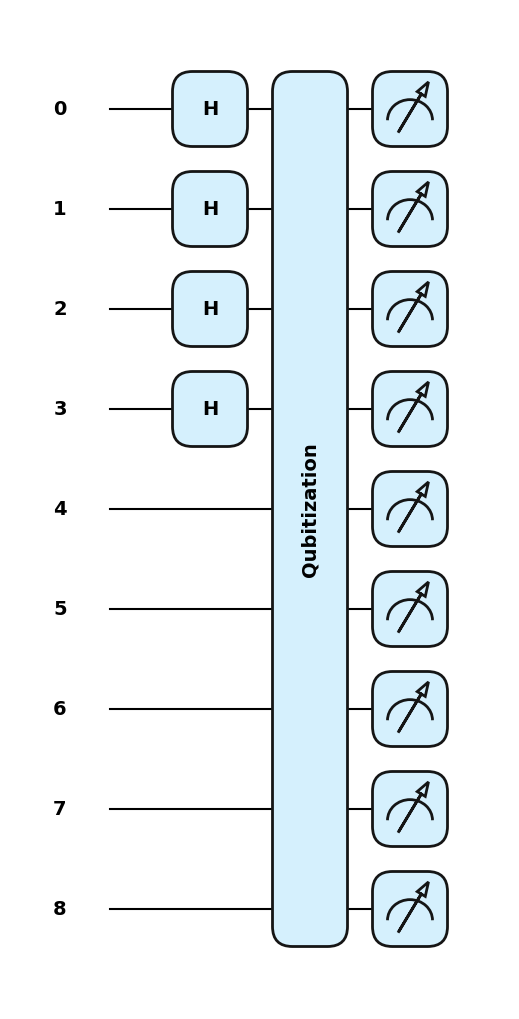

In [114]:
circuit_diagram = qml.draw_mpl(circuit, style='pennylane')
print(circuit_diagram())

In [115]:
# Step 5: Exact Ground State Calculation using NumPy's linalg.eig
eigenvalues, eigenvectors = np.linalg.eig(H_mat)

min_index = np.argmin(eigenvalues)
min_eigenvalue = eigenvalues[min_index]
min_eigenvector = eigenvectors[:, min_index]
# Print results
print("Exact ground state (via NumPy):", min_eigenvector)
print("Qubitization state vector:", state_vector)

Exact ground state (via NumPy): [0.47989754-0.j 0.25534815-0.j 0.16666667-0.j 0.22454939-0.j
 0.16666667-0.j 0.10878394-0.j 0.14656421-0.j 0.25534815-0.j
 0.25534815-0.j 0.14656421-0.j 0.10878394-0.j 0.16666667-0.j
 0.22454939-0.j 0.16666667-0.j 0.25534815-0.j 0.47989754+0.j]
Qubitization state vector: [-0.02404359+0.j -0.84424072+0.j  0.18252788+0.j  0.24788153+0.j
 -0.00397826+0.j -0.01793548+0.j -0.00228911+0.j -0.00596906+0.j
  0.26356639+0.j  0.1628789 +0.j  0.11300938+0.j  0.28585344+0.j
  0.00665659+0.j  0.0300104 +0.j  0.00383024+0.j  0.00998768+0.j]


In [105]:
circuit().shape

(256,)

In [66]:
len(alpha_k)

9

In [64]:
control_wires

[4, 5, 6, 7]

In [59]:
eigenvectors[0].shape

(16,)

In [86]:
## projector
import pennylane as qml
import numpy as np

# 定义量子设备
dev = qml.device('default.qubit', wires=2)

# 投影算符示例（Pauli-Z 和 Identity 的线性组合）
coeffs = np.array([1/2, 1/2])
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

# 使用 Qubitization 进行投影算符的量子化
@qml.qnode(dev)
def qubitization_circuit():
    # 使用 Qubitization 类来进行 qubitization
    qml.Hadamard(0)
    qml.RX(np.pi/2,[0])
    qml.Qubitization(qml.dot(coeffs,proj_unitaries), [1])  # 使用投影算符

    # 返回最终的量子态
    return qml.state()

# 绘制电路图
circuit_diagram = qml.draw_mpl(qubitization_circuit, style='pennylane')

# 执行并打印量子态
state = qubitization_circuit()[:2**1].real
state/=np.linalg.norm(state)
print(state)

# 打印电路图
# print(circuit_diagram())
qubitization_circuit().shape


[1. 0.]


(4,)

(<Figure size 500x300 with 1 Axes>, <Axes: >)

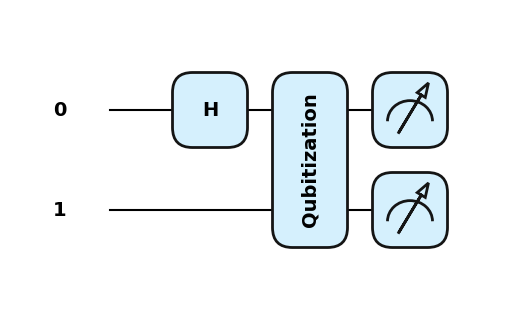

In [79]:
circuit_diagram()

(<Figure size 600x400 with 1 Axes>, <Axes: >)


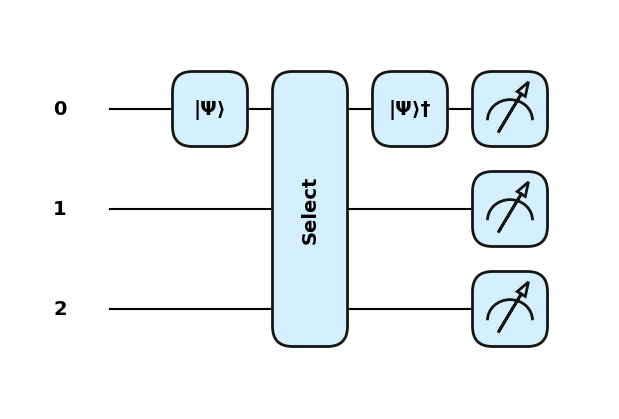

In [28]:
dev2 = qml.device("default.qubit", wires=3)
a = 0.25
b = 0.75

# matrix to be decomposed
A = np.array(
    [[a,  0, 0,  b],
     [0, -a, b,  0],
     [0,  b, a,  0],
     [b,  0, 0, -a]]
)

LCU = qml.pauli_decompose(A)
LCU_coeffs, LCU_ops = LCU.terms()
# normalized square roots of coefficients
alphas = (np.sqrt(LCU_coeffs) / np.linalg.norm(np.sqrt(LCU_coeffs)))
# unitaries
ops = LCU_ops
# relabeling wires: 0 → 1, and 1 → 2
unitaries = [qml.map_wires(op, {0: 1, 1: 2}) for op in ops]
@qml.qnode(dev2)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    # SEL
    qml.Select(unitaries, control=0)

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires=0))
    return qml.state()

circuit_diagram = qml.draw_mpl(lcu_circuit, style='pennylane')
print(circuit_diagram())

projector |0><0|

In [87]:
## projector
import pennylane as qml
import numpy as np

# 定义量子设备
dev = qml.device('default.qubit', wires=2)

# 投影算符示例（Pauli-Z 和 Identity 的线性组合）
coeffs = np.array([1/2, 1/2])
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

# 使用 Qubitization 进行投影算符的量子化
@qml.qnode(dev)
def qubitization_circuit():
    # 使用 Qubitization 类来进行 qubitization
    qml.Hadamard(0)
    qml.RX(np.pi/2,[0])
    qml.Qubitization(qml.dot(coeffs,proj_unitaries), [1])  # 使用投影算符

    # 返回最终的量子态
    return qml.state()

# 绘制电路图
circuit_diagram = qml.draw_mpl(qubitization_circuit, style='pennylane')

# 执行并打印量子态
state = qubitization_circuit()[:2**1].real
state/=np.linalg.norm(state)
print(state)


qubitization_circuit().shape

[1. 0.]


(4,)

(<Figure size 600x300 with 1 Axes>, <Axes: >)


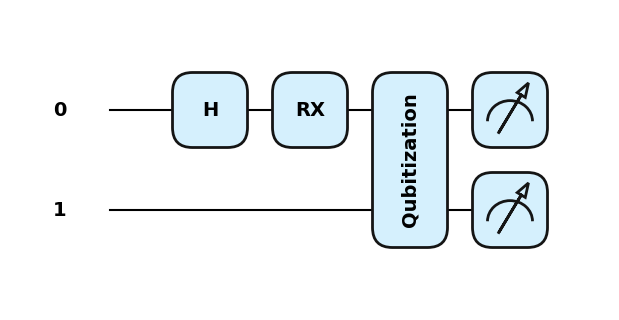

In [89]:
# 打印电路图
print(circuit_diagram())

(<Figure size 600x300 with 1 Axes>, <Axes: >)


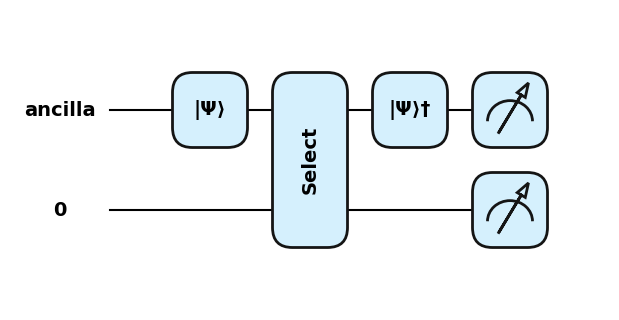

In [36]:
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))

proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]

def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires="ancilla")

    # SEL
    qml.Select(proj_unitaries, control="ancilla")

    # PREP_dagger
    qml.adjoint(qml.StatePrep(alphas, wires="ancilla"))
    return qml.state()
circuit_diagram = qml.draw_mpl(lcu_circuit, style='pennylane')
print(circuit_diagram())


In [32]:
alphas

tensor([0.70710678, 0.70710678], requires_grad=True)

(<Figure size 400x200 with 1 Axes>, <Axes: >)


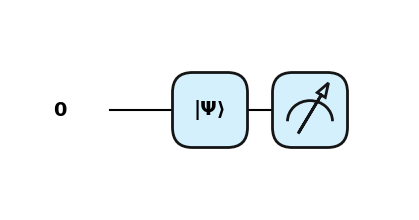

In [46]:
proj_unitaries = [qml.Identity(0), qml.PauliZ(0)]
dev = qml.device('default.qubit', wires=1)

# 为量子比特准备一个简单的状态
coeffs = np.array([1/2, 1/2])
alphas = np.sqrt(coeffs) / np.linalg.norm(np.sqrt(coeffs))  # 归一化

# 定义 LCU 电路
@qml.qnode(dev)
def lcu_circuit():  # block_encode
    # PREP
    qml.StatePrep(alphas, wires=0)

    return qml.state()
circuit_diagram = qml.draw_mpl(lcu_circuit, style='pennylane')
print(circuit_diagram())

In [45]:
coeffs = np.array([1/2, 1/2])
np.linalg.norm(np.sqrt(coeffs))

np.float64(1.0)

In [43]:
state = lcu_circuit()
state

tensor([0.70710678+0.j, 0.70710678+0.j], requires_grad=True)

In [3]:
import pennylane as qml

H = -0.4 * qml.Z(0) + 0.3 * qml.Z(1) + 0.4 * qml.Z(0) @ qml.Z(1)

#print(np.linalg.eigvalsh(qml.matrix(H).real)[0])
control_wires = [2, 3]
estimation_wires = [4, 5, 6, 7, 8, 9]

dev = qml.device("default.qubit")


@qml.qnode(dev)
def circuit():
    # Initialize the eigenstate |11⟩
    # for wire in [0, 1]:
    #     qml.X(wire)

    # Apply QPE with the qubitization operator
    qml.QuantumPhaseEstimation(
        qml.Qubitization(H, control_wires), estimation_wires=estimation_wires
    )

    return qml.probs(wires=estimation_wires)

### QSVT

In [2]:
target_poly = [0, -3 * 0.5, 0, 5 * 0.5]
target_poly[::-1]

[2.5, 0, -1.5, 0]

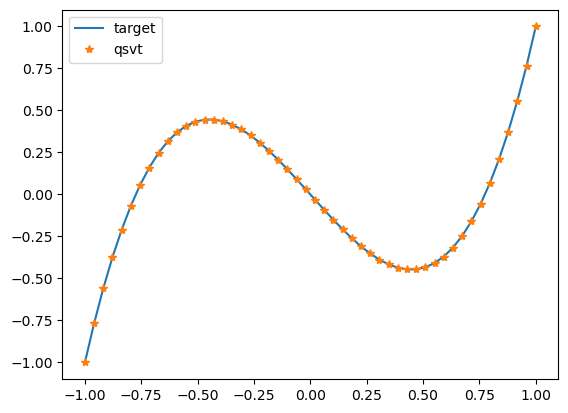

In [8]:
## qsvt
import matplotlib.pyplot as plt
def qsvt_circuit(a):
    qc = qml.qsvt(a, target_poly, encoding_wires=[0], block_encoding='embedding')
    return qc

def qsvt_out(a):
    qc = qsvt_circuit(a)
    out = qml.matrix(qc)
    return out[0,0]

a_vals = np.linspace(-1, 1, 50)
qsvt = [np.real(qsvt_out(a)) for a in a_vals]
target = [np.polyval(target_poly[::-1], a) for a in a_vals]

plt.plot(a_vals, target, label='target')
plt.plot(a_vals, qsvt, '*', label='qsvt')

plt.legend()
plt.show()
